# Computo de Alto Desempeño
## Ceballos Alberto
### Tarea clase 17 Mayo 2017

In [1]:
import numpy as np
import ipyparallel as ipp
import matplotlib.pyplot as plt
from time import time
c = ipp.Client()
dview = c[:]

####  1. Probar los primos de Mersenne con todas vistas: apply y map

##### Prime implementando for

In [2]:
def PrimeQA(x):
    import numpy as np
    return all(x%i for i in np.arange(int(x**0.5)+1)[2:])
PrimeQA(5), PrimeQA(31), PrimeQA(61)

(True, True, True)

* Tiempo para Prime con for - Map_sync

In [6]:
%timeit lista = dview.map_sync(PrimeQA, 2**np.arange(25)-1)
lista1 = []
for x in np.arange(25)[2:]:
    if lista[x] == True:
        lista1.append(x)
        print lista1

10 loops, best of 3: 33.2 ms per loop
[2]
[2, 3]
[2, 3, 5]
[2, 3, 5, 7]
[2, 3, 5, 7, 13]
[2, 3, 5, 7, 13, 17]
[2, 3, 5, 7, 13, 17, 19]


* Tiempo para Prime con for - Apply_sync

In [8]:
%timeit c[2].apply_sync(PrimeQA, 25)
lista1 = []
for x in np.arange(25)[2:]:
    if lista[x] == True:
        lista1.append(x)
        print lista1

100 loops, best of 3: 10.4 ms per loop
[2]
[2, 3]
[2, 3, 5]
[2, 3, 5, 7]
[2, 3, 5, 7, 13]
[2, 3, 5, 7, 13, 17]
[2, 3, 5, 7, 13, 17, 19]


#### Prime implementado con numpy

In [9]:
def PrimeQB(x):
    import numpy as np
    lista = np.arange(np.int(x**0.5)+1)[2:]
    residuos = np.mod(x, lista)
    return np.all(residuos)
PrimeQB(5), PrimeQB(31), PrimeQB(61)

(True, True, True)

* Tiempo para Prime con np - Map_sync

In [10]:
%timeit lista = dview.map_sync(PrimeQB, 2**np.arange(25)-1)
lista1 = []
for x in np.arange(25)[2:]:
    if lista[x] == True:
        lista1.append(x)
        print lista1

10 loops, best of 3: 34.1 ms per loop
[2]
[2, 3]
[2, 3, 5]
[2, 3, 5, 7]
[2, 3, 5, 7, 13]
[2, 3, 5, 7, 13, 17]
[2, 3, 5, 7, 13, 17, 19]


* Tiempo para Prime con np - Apply_sync

In [11]:
%timeit c[2].apply_sync(PrimeQB, 25)
lista1 = []
for x in np.arange(25)[2:]:
    if lista[x] == True:
        lista1.append(x)
        print lista1

100 loops, best of 3: 12.7 ms per loop
[2]
[2, 3]
[2, 3, 5]
[2, 3, 5, 7]
[2, 3, 5, 7, 13]
[2, 3, 5, 7, 13, 17]
[2, 3, 5, 7, 13, 17, 19]


#### 2. Verificar métodos _Load balanced_ para mejorar lo calculos

Administra la distribucion de tareas y es útil cuando se tienen muchas tareas que toman diferentes tiempos para ejecutarse.<br> Es decir, si se tiene un trabajo y da cada motor una parte igual, algunos motores pueden terminar más rápido y luego no hacer nada. Un mejor enfoque consiste en asignar el trabajo a cada motor apenas termine. De esta manera el trabajo se carga equilibrada sobre el clúster y se completará el proceso anterior.<br>
ipyparallel proporciona el LoadBalancedView para cada caso de uso exacto.<br>
Load_balance_view es útil si se ejecutan las tareas una por una o si las tareas toman una cantidad variable de tiempo.

##### LoadBalanceView y DirectView
LoadBalancedView se ejecuta en cualquier motor <br>
DirectView: tiene una ejecución directa en todos los motores<br>
Más información: <a href"http://ipython.org/ipython-doc/rel-0.11/ipython.pdf"> Python Documentation</a> Creación de instancia cliente y uso de LoadBalanceView en pag. 124

#### 3. All o np.all

* All: Devuelve True si bool (x) es True para todos los valores x en el iterable.Si la iterable está vacía, devuelva True.<br>
* Np.all: Devuelve True solo si todos los valores son True, a menos que se especifique `out`, en cuyo caso se devuelve una referencia a `out`.<br>

In [12]:
np.all([[True,True],[True,True]])

True

In [13]:
np.all([[True,True],[True,False]])

False

In [14]:
np.all([[False,True],[True,True]], axis=0)

array([False,  True], dtype=bool)

#### 4. Reemplazar por mod y quitar for de la lista : np.array([x%i for i in np.arange(int(x**0.5)+1)[2:]])

In [15]:
def PrimeQA(x):
    import numpy as np
    return np.all(np.array([x%i for i in np.arange(int(x**0.5)+1)[2:]]))
PrimeQA(7)

True

In [16]:
def PrimeQA(x):
    import numpy as np
    lista1 = np.arange(np.int(x**0.5)+1)[2:] 
    return np.all(np.array(np.mod(x, lista1)))
PrimeQA(7)

True

#### 5. Calculcar residuos creados con numpy utilizando todos los motores

In [17]:
def PrimeQB(x):
    import numpy as np
    lista = np.arange(np.int(x**0.5)+1)[2:]
    residuos = np.mod(x, lista)
    return np.all(residuos)
%timeit dview.map_sync(PrimeQB, np.arange(10))

10 loops, best of 3: 36.2 ms per loop


#### 6. Utilizar map para: 
_for med in np.arange(12,20):<br>
print np.mod(np.arange(24), med)_

In [18]:
def num():
    for med in np.arange(12,20):
        print np.mod(np.arange(24), med)
%timeit dview.map_sync(num(), np.arange(10))

[ 0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12  0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13  0  1  2  3  4  5  6  7  8  9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14  0  1  2  3  4  5  6  7  8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16  0  1  2  3  4  5  6]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17  0  1  2  3  4  5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18  0  1  2  3  4]
[ 0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12  0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13  0  1  2  3  4  5  6  7  8  9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14  0  1  2  3  4  5  6  7  8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]
[ 0  1  2  3  4  5  6  7  8  9 10 11 1

#### 7. Graficar tiempos con y sin vistas 

### PrimeQA con apply

In [19]:
def PrimeQA(x):
    import numpy as np
    return all(x%i for i in np.arange(int(x**0.5)+1)[2:])

In [20]:
list_apply1 = []
for i in np.arange(25):
    time1 = time()
    c[0].apply_sync(PrimeQA, 2**i)
    time2 = time()
    list_apply1.append(time2-time1) 
list_apply1

[0.012000083923339844,
 0.011999845504760742,
 0.012000083923339844,
 0.012000083923339844,
 0.011999845504760742,
 0.012000083923339844,
 0.016000032424926758,
 0.011999845504760742,
 0.00800013542175293,
 0.013000011444091797,
 0.0,
 0.014999866485595703,
 0.016000032424926758,
 0.0,
 0.015000104904174805,
 0.016000032424926758,
 0.015999794006347656,
 0.015000104904174805,
 0.0,
 0.016000032424926758,
 0.02500009536743164,
 0.011999845504760742,
 0.016000032424926758,
 0.016000032424926758,
 0.0]

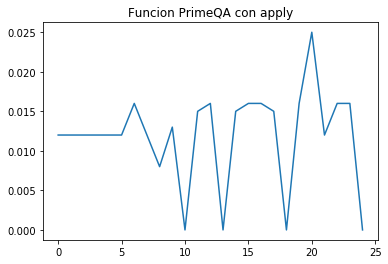

In [25]:
plt.title("Funcion PrimeQA con apply")
plt.plot(range(25), list_apply1)
plt.show()

### PrimeQA con map

In [26]:
list_map1 = []
for i in np.arange(25):
    time1 = time()
    dview.map_sync(PrimeQA, np.arange(25))
    time2 = time()
    list_map1.append(time2-time1) 
list_map1

[0.032000064849853516,
 0.03600001335144043,
 0.04399991035461426,
 0.032000064849853516,
 0.03099989891052246,
 0.031000137329101562,
 0.04699993133544922,
 0.03699994087219238,
 0.03600001335144043,
 0.019999980926513672,
 0.04700016975402832,
 0.03099989891052246,
 0.03099989891052246,
 0.032000064849853516,
 0.031000137329101562,
 0.03099989891052246,
 0.03099989891052246,
 0.032000064849853516,
 0.031000137329101562,
 0.03099989891052246,
 0.03099989891052246,
 0.032000064849853516,
 0.04699993133544922,
 0.031000137329101562,
 0.03099989891052246]

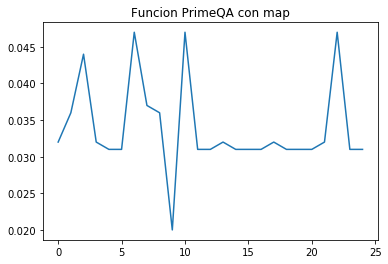

In [27]:
plt.title("Funcion PrimeQA con map")
plt.plot(range(25), list_map1)
plt.show()

### PrimeQB con apply

In [28]:
def PrimeQB(x):
    import numpy as np
    return np.all(np.array([x%i for i in np.arange(int(x**0.5)+1)[2:]]))

In [29]:
from time import time
list_apply2 = []
for i in np.arange(25):
    time1 = time()
    c[0].apply_sync(PrimeQB, 2**i)
    time2 = time()
    list_apply2.append(time2-time1) 
list_apply2

[0.012000083923339844,
 0.012000083923339844,
 0.007999897003173828,
 0.012000083923339844,
 0.016000032424926758,
 0.011999845504760742,
 0.016000032424926758,
 0.01399993896484375,
 0.012000083923339844,
 0.012000083923339844,
 0.011999845504760742,
 0.016000032424926758,
 0.012000083923339844,
 0.011999845504760742,
 0.017000198364257812,
 0.011999845504760742,
 0.012000083923339844,
 0.012000083923339844,
 0.015999794006347656,
 0.016000032424926758,
 0.016000032424926758,
 0.012000083923339844,
 0.016000032424926758,
 0.014999866485595703,
 0.016000032424926758]

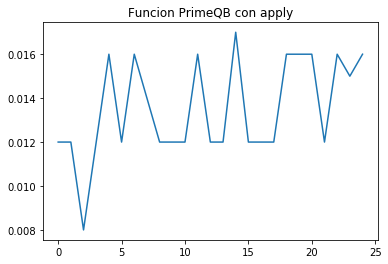

In [30]:
plt.title("Funcion PrimeQB con apply")
plt.plot(range(25), list_apply2)
plt.show()

### PrimeQB con map

In [31]:
from time import time
list_map2 = []
for i in np.arange(25):
    time1 = time()
    dview.map_sync(PrimeQB, np.arange(25))
    time2 = time()
    list_map2.append(time2-time1) 
list_map2

[0.03600001335144043,
 0.032000064849853516,
 0.039999961853027344,
 0.04399991035461426,
 0.0280001163482666,
 0.03099989891052246,
 0.032000064849853516,
 0.046000003814697266,
 0.03399991989135742,
 0.019999980926513672,
 0.032000064849853516,
 0.046000003814697266,
 0.032000064849853516,
 0.03099989891052246,
 0.04700016975402832,
 0.03099989891052246,
 0.03099989891052246,
 0.032000064849853516,
 0.031000137329101562,
 0.04699993133544922,
 0.03099989891052246,
 0.031000137329101562,
 0.03099989891052246,
 0.032000064849853516,
 0.03099989891052246]

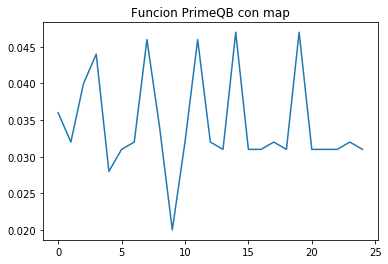

In [32]:
plt.title("Funcion PrimeQB con map")
plt.plot(range(25), list_map2)
plt.show()

### PrimeQC con apply

In [34]:
def PrimeQC(x):
    import numpy as np
    lista = np.arange(np.int(x**0.5)+1)[2:]
    residuos = np.mod(x, lista)
    return np.all(residuos)

In [35]:
from time import time
list_apply3 = []
for i in np.arange(25):
    time1 = time()
    c[0].apply_sync(PrimeQC, 2**i)
    time2 = time()
    list_apply3.append(time2-time1) 
list_apply3

[0.012000083923339844,
 0.011999845504760742,
 0.012000083923339844,
 0.012000083923339844,
 0.015999794006347656,
 0.012000083923339844,
 0.016000032424926758,
 0.012000083923339844,
 0.003999948501586914,
 0.016000032424926758,
 0.014999866485595703,
 0.016000032424926758,
 0.015000104904174805,
 0.015999794006347656,
 0.016000032424926758,
 0.015000104904174805,
 0.0,
 0.016000032424926758,
 0.02499985694885254,
 0.016000032424926758,
 0.016000032424926758,
 0.016000032424926758,
 0.015000104904174805,
 0.015999794006347656,
 0.016000032424926758]

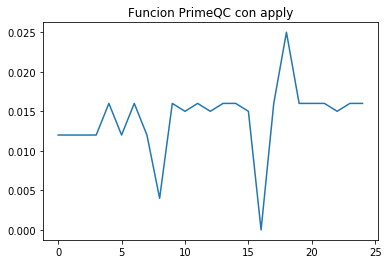

In [36]:
plt.title("Funcion PrimeQC con apply")
plt.plot(range(25), list_apply3)
plt.show()

### PrimeQC con map

In [37]:
from time import time
list_map3 = []
for i in np.arange(25):
    time1 = time()
    dview.map_sync(PrimeQC, np.arange(25))
    time2 = time()
    list_map3.append(time2-time1) 
list_map3

[0.0840001106262207,
 0.04399991035461426,
 0.031000137329101562,
 0.03099989891052246,
 0.03099989891052246,
 0.03800010681152344,
 0.03600001335144043,
 0.03099989891052246,
 0.031000137329101562,
 0.031999826431274414,
 0.031000137329101562,
 0.03099989891052246,
 0.031000137329101562,
 0.04699993133544922,
 0.032000064849853516,
 0.03099989891052246,
 0.031000137329101562,
 0.03099989891052246,
 0.032000064849853516,
 0.03099989891052246,
 0.04699993133544922,
 0.031000137329101562,
 0.03099989891052246,
 0.031000137329101562,
 0.031999826431274414]

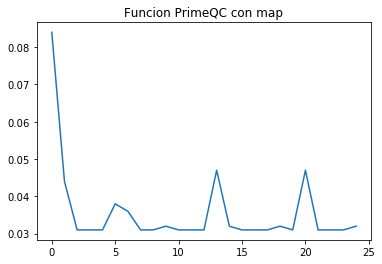

In [38]:
plt.title("Funcion PrimeQC con map")
plt.plot(range(25), list_map3)
plt.show()

## Gráficas de las tres funciones 

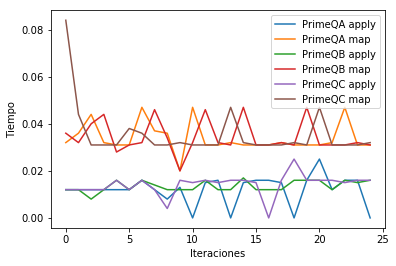

In [41]:
plt.plot(range(25), list_apply1, label = 'PrimeQA apply') 
plt.plot(range(25), list_map1, label = "PrimeQA map")
plt.plot(range(25), list_apply2, label = "PrimeQB apply")
plt.plot(range(25), list_map2, label = "PrimeQB map")
plt.plot(range(25), list_apply3, label = "PrimeQC apply")
plt.plot(range(25), list_map3, label = "PrimeQC map")
plt.legend(loc = "upper right")
plt.xlabel("Iteraciones")
plt.ylabel("Tiempo")
plt.show()